In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import pyodbc
import joblib
import warnings
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
import os
warnings.filterwarnings('ignore')
import urllib
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sqlalchemy import create_engine

plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Database connection
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DESKTOP-KIDL0VQ\\SQLEXPRESS;"
    "DATABASE=RealEstate_DWH;"
    "Trusted_Connection=yes;")

connection_string = f"mssql+pyodbc:///?odbc_connect={params}"
engine = create_engine(connection_string)

In [3]:
df = pd.read_sql('select * from [dbo].[ML_model] where SalesType = 1', con=engine)
df = df.drop(['DailyRent', 'SalesType'], axis=1)
df

,TargetPrice,CategoryID,CategoryName,FloorNumber,FieldAreaSqm,CountRoom,HasTitle,IsRepaired,CityLatitude,CityLongitude,PropertyLatitude,PropertyLongitude,SellerType
0,54500,2,Yeni tikili,1.0,542.0,1,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
1,120000,2,Yeni tikili,3.0,902.0,3,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
2,107000,2,Yeni tikili,9.0,1052.0,3,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
3,175000,2,Yeni tikili,4.0,1002.0,3,True,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
4,65000,2,Yeni tikili,1.0,572.0,2,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7511,62000,2,Yeni tikili,5.0,432.0,2,True,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
7512,93000,2,Yeni tikili,2.0,782.0,2,True,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
7513,52000,2,Yeni tikili,6.0,832.0,2,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0
7514,66000,2,Yeni tikili,8.0,662.0,2,False,None,40.4093,49.8671,40.37336527040737,49.835700083690874,2.0


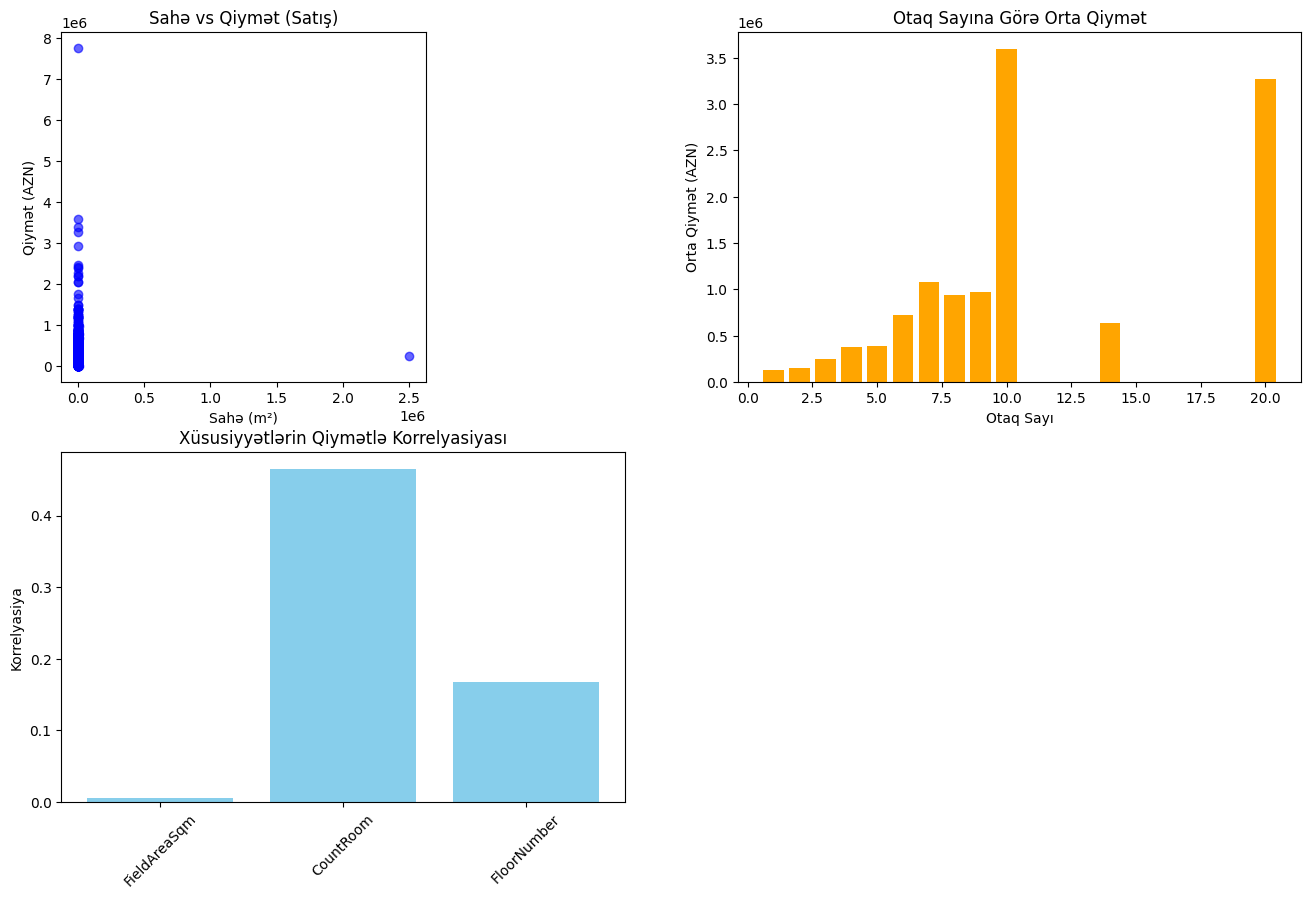

In [4]:
X = df[['FieldAreaSqm', 'CountRoom', 'FloorNumber', 'PropertyLatitude', 'PropertyLongitude']]
y = df['TargetPrice']

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.scatter(X['FieldAreaSqm'], df['TargetPrice'], alpha=0.6, color='blue')
plt.title('Sahə vs Qiymət (Satış)')
plt.xlabel('Sahə (m²)')
plt.ylabel('Qiymət (AZN)')

plt.subplot(2, 2, 2)
room_avg_price = df.groupby('CountRoom')['TargetPrice'].mean()
plt.bar(room_avg_price.index, room_avg_price.values, color='orange')
plt.title('Otaq Sayına Görə Orta Qiymət')
plt.xlabel('Otaq Sayı')
plt.ylabel('Orta Qiymət (AZN)')

plt.subplot(2, 2, 3)
correlation_features = ['FieldAreaSqm', 'CountRoom', 'FloorNumber']
correlations = [X[feature].corr(y) for feature in correlation_features]
plt.bar(correlation_features, correlations, color='skyblue')
plt.title('Xüsusiyyətlərin Qiymətlə Korrelyasiyası')
plt.xticks(rotation=45)
plt.ylabel('Korrelyasiya')

plt.tight_layout()
plt.show()

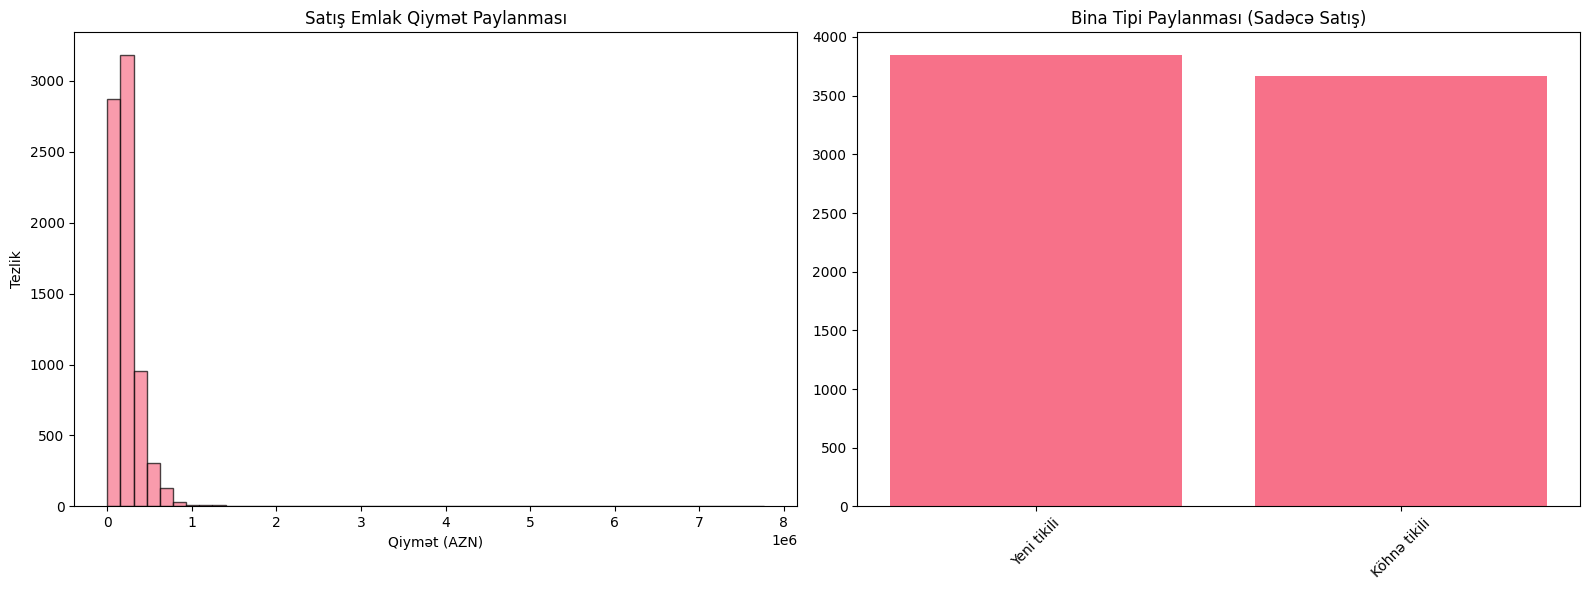

In [5]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(df['TargetPrice'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Satış Emlak Qiymət Paylanması')
plt.xlabel('Qiymət (AZN)')
plt.ylabel('Tezlik')

plt.subplot(1, 2, 2)
building_counts = df['CategoryName'].value_counts()
plt.bar(building_counts.index, building_counts.values)
plt.title('Bina Tipi Paylanması (Sadəcə Satış)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
METRO_STATIONS = {
    '20 Yanvar': {'lat': 40.4035, 'lon': 49.8295},
    '28 May': {'lat': 40.3777, 'lon': 49.8504},
    '8 Noyabr': {'lat': 40.4048, 'lon': 49.8425},
    'Avtovağzal': {'lat': 40.4134, 'lon': 49.8020},
    'Azadlıq Prospekti': {'lat': 40.4191, 'lon': 49.8316},
    'Bakmil': {'lat': 40.4113, 'lon': 49.8827},
    'Dərnəgül': {'lat': 40.4216, 'lon': 49.8234},
    'Elmlər Akademiyası': {'lat': 40.3742, 'lon': 49.8299},
    'Əhmədli': {'lat': 40.3883, 'lon': 49.9383},
    'Gənclik': {'lat': 40.3973, 'lon': 49.8676},
    'Həzi Aslanov': {'lat': 40.3925, 'lon': 49.9530},
    'İçərişəhər': {'lat': 40.3662, 'lon': 49.8351},
    'İnşaatçılar': {'lat': 40.3786, 'lon': 49.8199},
    'Koroğlu': {'lat': 40.4114, 'lon': 49.9360},
    'Memar Əcəmi': {'lat': 40.3976, 'lon': 49.8232},
    'Nəriman Nərimanov': {'lat': 40.4009, 'lon': 49.8798},
    'Nəsimi': {'lat': 40.3856, 'lon': 49.8615},
    'Neftçilər': {'lat': 40.4071, 'lon': 49.9654},
    'Nizami': {'lat': 40.3787, 'lon': 49.8417},
    'Qara Qarayev': {'lat': 40.4031, 'lon': 49.9498},
    'Sahil': {'lat': 40.3722, 'lon': 49.8414},
    'Xətai': {'lat': 40.3847, 'lon': 49.8945},
    'Xalqlar Dostluğu': {'lat': 40.3955, 'lon': 49.9452},
    'Xocəsən': {'lat': 40.4365, 'lon': 49.7726},
    'Ulduz': {'lat': 40.4137, 'lon': 49.9070},
    'Cəfər Cabbarlı': {'lat': 40.3775, 'lon': 49.8497}
}


DISTRICTS = {
    'Yasamal': {'lat': 40.3836, 'lon': 49.8289, 'premium': 1.3},
    'Nərimanov': {'lat': 40.4076, 'lon': 49.8675, 'premium': 1.4},
    'Nəsimi': {'lat': 40.3860, 'lon': 49.8405, 'premium': 1.5},
    'Sabunçu': {'lat': 40.4489, 'lon': 49.9496, 'premium': 0.9},
    'Suraxanı': {'lat': 40.3965, 'lon': 50.0047, 'premium': 0.8},
    'Xətai': {'lat': 40.3779, 'lon': 49.9050, 'premium': 1.2},
    'Səbail': {'lat': 40.3599, 'lon': 49.8325, 'premium': 1.7},
    'Binəqədi': {'lat': 40.4255, 'lon': 49.8152, 'premium': 1.0},
    'Qaradağ': {'lat': 40.3213, 'lon': 49.7245, 'premium': 0.7},
    'Xəzər': {'lat': 40.3765, 'lon': 50.0456, 'premium': 0.8},
    'Pirallahı': {'lat': 40.5083, 'lon': 50.2923, 'premium': 0.6}
}

# VIP lokasiyalar
VIP_LOCATIONS = {
    'İçərişəhər': {'lat': 40.366499, 'lon': 49.834388},           
    'Tarqovı (Nizami küç.)': {'lat': 40.376793, 'lon': 49.841630}, 
    'Flame Towers ətrafı': {'lat': 40.359795, 'lon': 49.828002},   
    'Neftçilər prospekti': {'lat': 40.368870, 'lon': 49.846514},   
    'White City (Ağ Şəhər)': {'lat': 40.371014, 'lon': 49.876761}, 
    'Port Baku': {'lat': 40.373292, 'lon': 49.860967},            
    'Şüvəlan': {'lat': 40.481950, 'lon': 50.123390},             
    'Bilgəh': {'lat': 40.574765, 'lon': 50.006822},               
    'Nardaran': {'lat': 40.573932, 'lon': 50.035234},            
    'Buzovna': {'lat': 40.511924, 'lon': 50.136145},            
    'Badamdar (yuxarı)': {'lat': 40.351998, 'lon': 49.829225},
    'Təzə Pir': {'lat': 40.370770, 'lon': 49.836145},             
    'Elmlər Akademiyası': {'lat': 40.378536, 'lon': 49.829172},   
    'Hyatt Regency': {'lat': 40.391261, 'lon': 49.827713},
    'Botanika bağı': {'lat': 40.370050, 'lon': 49.831530}
}

CITY_CENTER = {'lat': 40.3630, 'lon': 49.8338}

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c * 1000

def find_closest_metro(lat, lon):
    min_dist = float('inf')
    closest_metro = None
    for metro_name, coords in METRO_STATIONS.items():
        dist = calculate_distance(lat, lon, coords['lat'], coords['lon'])
        if dist < min_dist:
            min_dist = dist
            closest_metro = metro_name
    return min_dist, closest_metro

def find_closest_district(lat, lon):
    min_dist = float('inf')
    district_premium = 1.0
    closest_district = None
    for district_name, coords in DISTRICTS.items():
        dist = calculate_distance(lat, lon, coords['lat'], coords['lon'])
        if dist < min_dist:
            min_dist = dist
            district_premium = coords['premium']
            closest_district = district_name
    return district_premium, min_dist, closest_district

def find_closest_vip_location(lat, lon, max_distance=5000):
    min_dist = float('inf')
    for vip_name, coords in VIP_LOCATIONS.items():
        dist = calculate_distance(lat, lon, coords['lat'], coords['lon'])
        if dist < min_dist:
            min_dist = dist
    return min_dist if min_dist <= max_distance else 6000

In [8]:
mean = df['TargetPrice'].mean()
std = df['TargetPrice'].std()
z_scores = np.abs((df['TargetPrice'] - mean) / std)

# IQR method
Q1 = df['TargetPrice'].quantile(0.25)
Q3 = df['TargetPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Combined outlier detection
outliers_zscore = z_scores > 3
outliers_iqr = (df['TargetPrice'] < lower_bound) | (df['TargetPrice'] > upper_bound)
outliers_combined = outliers_zscore | outliers_iqr

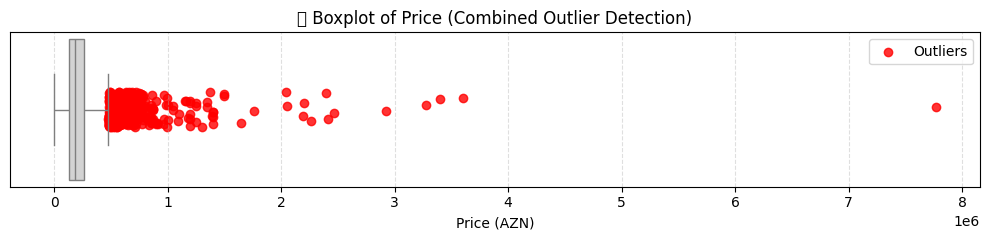

In [9]:
colors = ['red' if outlier else 'green' for outlier in outliers_combined]

plt.figure(figsize=(10, 2.5))
sns.boxplot(x=df['TargetPrice'], color='lightgray', fliersize=0)

outlier_values = df['TargetPrice'][outliers_combined]
outlier_positions = np.random.uniform(low=-0.1, high=0.1, size=len(outlier_values))
plt.scatter(outlier_values, outlier_positions, color='red', label='Outliers', alpha=0.8)

plt.title('📦 Boxplot of Price (Combined Outlier Detection)')
plt.xlabel('Price (AZN)')
plt.yticks([])
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
original_count = len(df)

In [11]:
df = df[~outliers_combined]

# Data cleaning
numeric_columns = ['TargetPrice', 'FloorNumber', 'FieldAreaSqm', 'CountRoom', 'PropertyLatitude', 'PropertyLongitude']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if 'HasTitle' in df.columns:
    df['HasTitle'] = df['HasTitle'].astype(bool)
if 'IsRepaired' in df.columns:
    df['IsRepaired'] = df['IsRepaired'].astype(bool)

df = df.dropna(subset=['TargetPrice', 'FieldAreaSqm', 'CountRoom', 'PropertyLatitude', 'PropertyLongitude'])

# Refined range filtering
df = df[df['TargetPrice'] >= 20000]
df = df[df['TargetPrice'] <= 800000]
df = df[df['FieldAreaSqm'] >= 15]
df = df[df['FieldAreaSqm'] <= 350]
df = df[df['CountRoom'] >= 1]
df = df[df['CountRoom'] <= 8]
df = df[df['FloorNumber'] >= 1]
df = df[df['FloorNumber'] <= 35]

# Bakı koordinatları - genişləndirilmiş
df = df[(df['PropertyLatitude'] >= 40.20) & (df['PropertyLatitude'] <= 40.70)]
df = df[(df['PropertyLongitude'] >= 49.50) & (df['PropertyLongitude'] <= 50.50)]

In [12]:
cleaned_count = len(df)

In [13]:
print(f"{original_count} ----→ {cleaned_count}")

7516 ----→ 5064


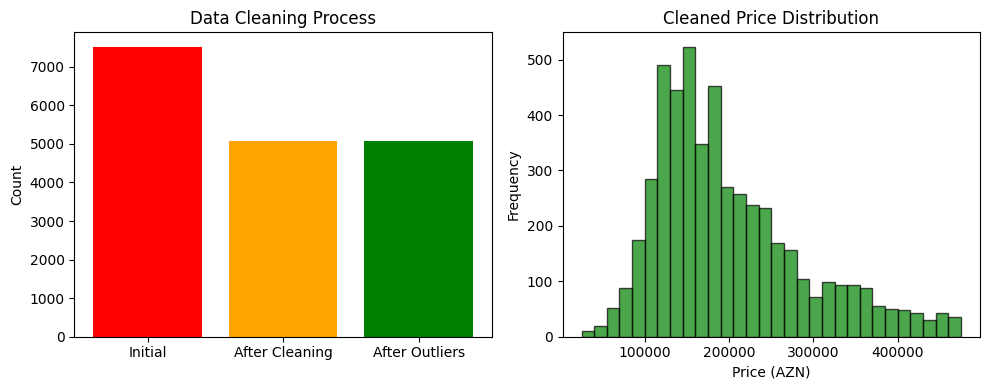

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
stages = ['Initial', 'After Cleaning', 'After Outliers']
counts = [original_count, len(df) + (cleaned_count - len(df))//2, len(df)]
plt.bar(stages, counts, color=['red', 'orange', 'green'])
plt.title('Data Cleaning Process')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df['TargetPrice'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Cleaned Price Distribution')
plt.xlabel('Price (AZN)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
df['area'] = df['FieldAreaSqm']
df['rooms'] = df['CountRoom']
df['floor'] = df['FloorNumber']
df['lat'] = df['PropertyLatitude']
df['lon'] = df['PropertyLongitude']

df['is_new'] = (df['CategoryName'] == 'Yeni tikili').astype(int) if 'CategoryName' in df.columns else 0
df['has_title'] = df['HasTitle'].astype(int) if 'HasTitle' in df.columns else 1
df['is_repaired'] = df['IsRepaired'].astype(int) if 'IsRepaired' in df.columns else 1

if 'SellerType' in df.columns:
    if df['SellerType'].dtype in ['int64', 'float64']:
        df['is_agency'] = (df['SellerType'] == 1).astype(int)
    else:
        df['is_agency'] = (df['SellerType'].str.contains('Agency', case=False, na=False)).astype(int)
else:
    df['is_agency'] = 0

# Əsas sahə xüsusiyyətləri
df['area_per_room'] = df['area'] / df['rooms']
df['price_per_sqm'] = df['TargetPrice'] / df['area']
df['room_area_ratio'] = df['rooms'] / df['area']
df['floor_area_score'] = df['floor'] * np.log1p(df['area'])  
df['room_efficiency'] = df['area'] / (df['rooms'] + 1)

In [16]:
metro_info = df.apply(lambda row: find_closest_metro(row['lat'], row['lon']), axis=1)
df['metro_distance'] = [info[0] for info in metro_info]
df['closest_metro'] = [info[1] for info in metro_info]

district_info = df.apply(lambda row: find_closest_district(row['lat'], row['lon']), axis=1)
df['district_premium'] = [info[0] for info in district_info]
df['district_distance'] = [info[1] for info in district_info]

df['vip_distance'] = df.apply(lambda row: find_closest_vip_location(row['lat'], row['lon']), axis=1)
df['center_distance'] = df.apply(lambda row: calculate_distance(row['lat'], row['lon'], CITY_CENTER['lat'], CITY_CENTER['lon']), axis=1)

# BOOLEAN LOCATION FEATURES
df['is_near_metro'] = (df['metro_distance'] < 800).astype(int)
df['is_central'] = (df['center_distance'] < 4000).astype(int)
df['is_premium_area'] = (df['district_premium'] > 1.3).astype(int)
df['is_vip_close'] = (df['vip_distance'] < 1500).astype(int)
df['is_vip_super'] = (df['vip_distance'] < 500).astype(int)

# FLOOR FEATURES
df['is_good_floor'] = ((df['floor'] >= 2) & (df['floor'] <= 10)).astype(int)
df['is_middle_floor'] = ((df['floor'] >= 3) & (df['floor'] <= 7)).astype(int)
df['is_high_floor'] = (df['floor'] >= 10).astype(int)
df['is_penthouse'] = (df['floor'] >= 15).astype(int)
df['floor_ratio'] = df['floor'] / (df['floor'] + 10)  # Normalized floor

# AREA FEATURES 
df['is_optimal_area'] = ((df['area'] >= 60) & (df['area'] <= 120)).astype(int)
df['area_efficiency'] = df['area'] / (df['rooms'] * 15)  # 15 m² ideal room size
df['room_size_score'] = np.clip(df['area_per_room'] / 25, 0, 2)  # 25 m² ideal

# 0: compact, 1: normal, 2: spacious
df['room_size_type'] = pd.cut(df['area_per_room'],bins=[0, 20, 30, float('inf')],labels=[0, 1, 2]).astype(int)

# 0: ground, 1: low, 2: mid, 3: high
df['floor_group'] = pd.cut(df['floor'], bins=[0, 1, 3, 10, float('inf')],labels=[0, 1, 2, 3]  ).astype(int)


df['gold_combo'] = df['is_new'] * df['is_premium_area'] * df['is_near_metro']
df['platinum_combo'] = df['is_vip_super'] * df['is_new'] * df['has_title']
df['premium_central'] = df['is_premium_area'] * df['is_central']


df['luxury_score'] = (
    df['is_new'] * 3 +
    df['is_vip_close'] * 2 +
    df['is_premium_area'] * 2 +
    df['has_title'] * 1 +
    df['is_middle_floor'] * 1)


df['infrastructure_score'] = (
    1 / (df['metro_distance'] + 100) * 0.5 +
    1 / (df['vip_distance'] + 100) * 0.3 +
    1 / (df['center_distance'] + 100) * 0.2)

df['accessibility_score'] = (
    df['is_near_metro'] * 3 +
    (df['is_central']).astype(int) * 2 +
    (df['is_vip_close']).astype(int) * 2)


metro_factor = np.maximum(0, 1 - df['metro_distance'] / 1500)
vip_factor = np.maximum(0, 1 - df['vip_distance'] / 2000)
center_factor = np.maximum(0, 1 - df['center_distance'] / 8000)
df['location_premium'] = (
    metro_factor * 0.4 +
    vip_factor * 0.3 +
    center_factor * 0.2 +
    (df['district_premium'] - 1) * 0.1)

# polyminal features
df['area_squared'] = df['area'] ** 2

In [17]:
feature_cols = [
    'area', 'rooms', 'floor', 'lat', 'lon', 
    'area_per_room', 'room_area_ratio', 'floor_area_score', 'room_efficiency',
    'metro_distance', 'center_distance', 'vip_distance', 
    'district_premium', 'district_distance',
    'is_new', 'has_title', 'is_near_metro', 
    'is_central', 'is_premium_area', 'is_vip_close', 'is_vip_super',
    'is_good_floor', 'is_middle_floor', 'is_high_floor', 'is_penthouse',
    'is_optimal_area',
    'area_efficiency', 'room_size_score', 'floor_ratio', 'location_premium',
    'luxury_score', 'infrastructure_score', 'accessibility_score',
    'area_squared',
    'room_size_type', 'floor_group',
    'gold_combo', 'platinum_combo', 'premium_central']

X = df[feature_cols]
y = df['TargetPrice']

In [18]:
selector = SelectKBest(score_func=f_regression, k=25)  # Ən yaxşı 25 xüsusiyyət
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = pd.DataFrame(X_selected, columns=selected_features)

In [19]:
price_bins = [0, 80000, 150000, 250000, float('inf')]
price_labels = ['Budget', 'Mid', 'Premium', 'Luxury']
df['price_category'] = pd.cut(df['TargetPrice'], bins=price_bins, labels=price_labels)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['price_category'])

In [21]:
rf_params = {
    'n_estimators': [200, 250, 300],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_
print(f"Best RF : {rf_grid.best_params_}")

Best RF : {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [22]:
gb_params = {
    'n_estimators': [150, 200, 250],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.05, 0.1, 0.12],
    'subsample': [0.8, 0.9, 1.0]}

gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, scoring='r2', n_jobs=-1, verbose=0)
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

print(f"Best GB: {gb_grid.best_params_}")

Best GB: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8}


In [23]:
models = {
    'mod_RandomForest': best_rf,
    'mod_GradientBoosting': best_gb,
    'ExtraTrees': ExtraTreesRegressor(n_estimators=200, max_depth=25, min_samples_split=3, random_state=42, n_jobs=-1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'Ridge': Ridge(alpha=10.0, random_state=42)}

In [24]:
model_results = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{name} training ")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    
    # Train and test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Detailed metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    # Accuracy calculations - təkmilləşdirilmiş
    relative_errors = np.abs((y_test - y_pred) / y_test)
    accuracy = np.mean(relative_errors < 0.15) * 100
    
    model_results[name] = {
        'model': model,
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred}
    
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:,.0f} AZN")
    print(f"MAE: {mae:,.0f} AZN")
    print(f"MAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.1f}%")
    print(f"Cross-Validation: {cv_scores.mean():.4f} (±{cv_scores.std():.3f})")


mod_RandomForest training 
R² Score: 0.8188
RMSE: 37,105 AZN
MAE: 25,342 AZN
MAPE: 14.95%
Accuracy: 68.4%
Cross-Validation: 0.8351 (±0.005)

mod_GradientBoosting training 
R² Score: 0.8286
RMSE: 36,086 AZN
MAE: 25,056 AZN
MAPE: 14.51%
Accuracy: 68.5%
Cross-Validation: 0.8365 (±0.011)

ExtraTrees training 
R² Score: 0.8162
RMSE: 37,366 AZN
MAE: 25,214 AZN
MAPE: 14.62%
Accuracy: 68.7%
Cross-Validation: 0.8299 (±0.011)

ElasticNet training 
R² Score: 0.7538
RMSE: 43,243 AZN
MAE: 31,072 AZN
MAPE: 19.22%
Accuracy: 56.2%
Cross-Validation: 0.7637 (±0.008)

Ridge training 
R² Score: 0.7580
RMSE: 42,874 AZN
MAE: 30,618 AZN
MAPE: 18.94%
Accuracy: 57.7%
Cross-Validation: 0.7672 (±0.008)


In [25]:
sorted_models = sorted(model_results.items(), key=lambda x: x[1]['r2'], reverse=True)
top_4_models = sorted_models[:4]

ensemble_models = []
weights = []

for name, result in top_4_models:
    ensemble_models.append((name.lower().replace('_', ''), result['model']))
    weights.append(result['r2'])

total_weight = sum(weights)
weights = [w/total_weight for w in weights]

ensemble = VotingRegressor(ensemble_models, weights=weights)
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)

ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred) * 100

ensemble_relative_errors = np.abs((y_test - ensemble_pred) / y_test)
ensemble_accuracy = np.mean(ensemble_relative_errors < 0.15) * 100

print(f"ENSEMBLE MODELS: {[name for name, _ in top_4_models]}")
print(f"WEIGHTS: {[f'{w:.3f}' for w in weights]}")
print(f"ENSEMBLE RESULTS:")
print(f"R² Score: {ensemble_r2:.4f}")
print(f"RMSE: {ensemble_rmse:,.0f} AZN")
print(f"MAE: {ensemble_mae:,.0f} AZN")
print(f"MAPE: {ensemble_mape:.2f}%")
print(f"Accuracy: {ensemble_accuracy:.1f}%")

ENSEMBLE MODELS: ['mod_GradientBoosting', 'mod_RandomForest', 'ExtraTrees', 'Ridge']
WEIGHTS: ['0.257', '0.254', '0.253', '0.235']
ENSEMBLE RESULTS:
R² Score: 0.8270
RMSE: 36,247 AZN
MAE: 25,258 AZN
MAPE: 14.94%
Accuracy: 68.1%


In [26]:
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['r2'])
best_individual = model_results[best_model_name]

if ensemble_r2 > best_individual['r2']:
    final_model = ensemble
    final_name = "Enhanced_Ensemble"
    final_r2 = ensemble_r2
    final_acc = ensemble_accuracy
    final_mae = ensemble_mae
    final_mape = ensemble_mape
    final_pred = ensemble_pred
    print(f"Best: Enhanced Ensemble (R²={ensemble_r2:.4f})")
else:
    final_model = best_individual['model']
    final_name = best_model_name
    final_r2 = best_individual['r2']
    final_acc = best_individual['accuracy']
    final_mae = best_individual['mae']
    final_mape = best_individual['mape']
    final_pred = best_individual['predictions']
    print(f"Best {best_model_name} (R²={final_r2:.4f})")


Best mod_GradientBoosting (R²=0.8286)


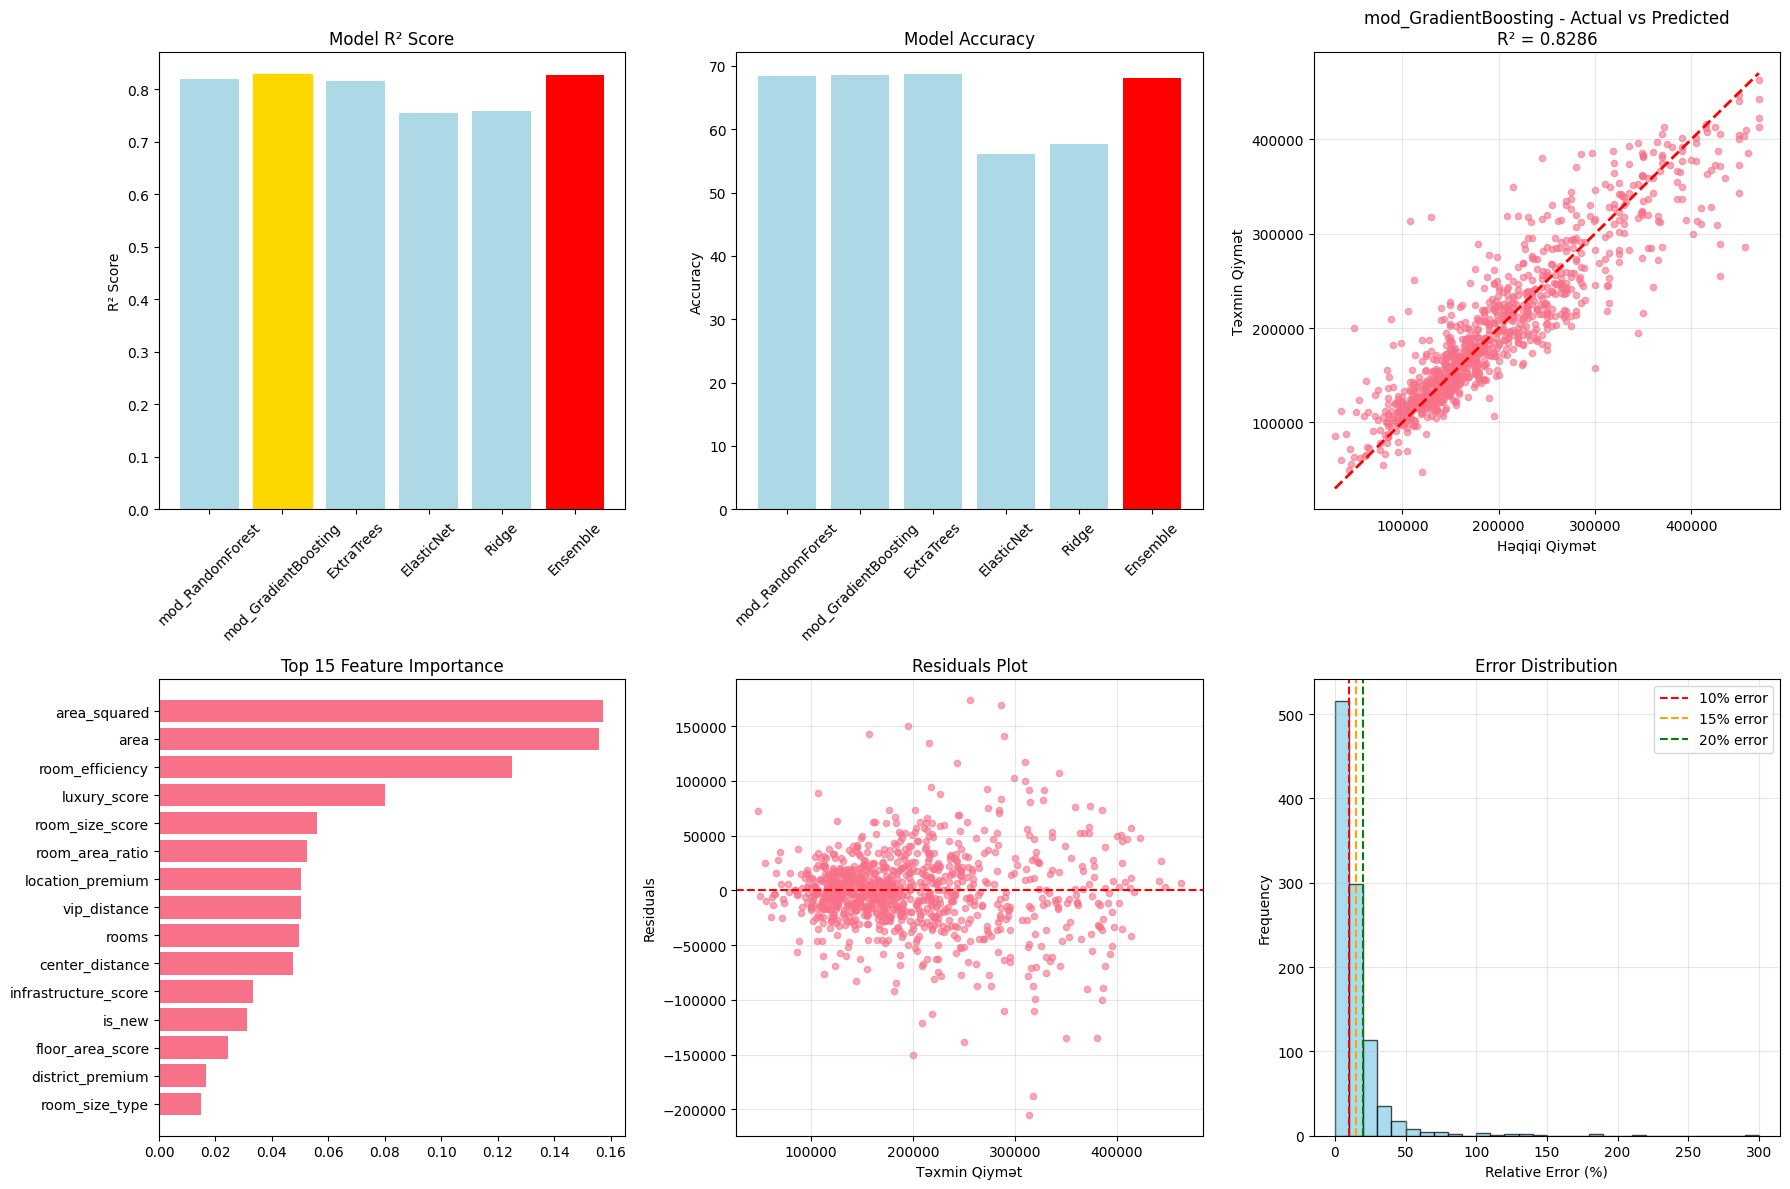

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

model_names = list(model_results.keys()) + ['Ensemble']
r2_scores = [model_results[name]['r2'] for name in model_results.keys()] + [ensemble_r2]
acc_scores = [model_results[name]['accuracy'] for name in model_results.keys()] + [ensemble_accuracy]

colors = ['lightblue'] * len(model_results) + ['red']
bars = axes[0,0].bar(model_names, r2_scores, color=colors)
axes[0,0].set_title('Model R² Score')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)


best_idx = np.argmax(r2_scores)
bars[best_idx].set_color('gold')


axes[0,1].bar(model_names, acc_scores, color=colors)
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].tick_params(axis='x', rotation=45)


axes[0,2].scatter(y_test, final_pred, alpha=0.6, s=20)
min_val, max_val = min(y_test.min(), final_pred.min()), max(y_test.max(), final_pred.max())
axes[0,2].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0,2].set_title(f'{final_name} - Actual vs Predicted\nR² = {final_r2:.4f}')
axes[0,2].set_xlabel('Həqiqi Qiymət')
axes[0,2].set_ylabel('Təxmin Qiymət')
axes[0,2].grid(True, alpha=0.3)


if hasattr(best_rf, 'feature_importances_'):
    rf_importance = pd.DataFrame({'feature': selected_features,'importance': best_rf.feature_importances_}).sort_values('importance', ascending=True).tail(15)
    axes[1,0].barh(range(len(rf_importance)), rf_importance['importance'])
    axes[1,0].set_yticks(range(len(rf_importance)))
    axes[1,0].set_yticklabels(rf_importance['feature'])
    axes[1,0].set_title('Top 15 Feature Importance')


residuals = y_test - final_pred
axes[1,1].scatter(final_pred, residuals, alpha=0.6, s=20)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_title('Residuals Plot')
axes[1,1].set_xlabel('Təxmin Qiymət')
axes[1,1].set_ylabel('Residuals')
axes[1,1].grid(True, alpha=0.3)


relative_errors = np.abs((y_test - final_pred) / y_test) * 100
axes[1,2].hist(relative_errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,2].axvline(x=10, color='red', linestyle='--', label='10% error')
axes[1,2].axvline(x=15, color='orange', linestyle='--', label='15% error')
axes[1,2].axvline(x=20, color='green', linestyle='--', label='20% error')
axes[1,2].set_title('Error Distribution')
axes[1,2].set_xlabel('Relative Error (%)')
axes[1,2].set_ylabel('Frequency')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
model_package = {
    'final_model': final_model,
    'final_model_name': final_name,
    'individual_models': {name: result['model'] for name, result in model_results.items()},
    'ensemble_model': ensemble,
    'feature_selector': selector,
    'selected_features': selected_features,
    'all_features': feature_cols,
    
    'coordinates': {
        'metro_stations': METRO_STATIONS,
        'districts': DISTRICTS,
        'vip_locations': VIP_LOCATIONS,
        'city_center': CITY_CENTER},
    
    'performance': {
        'final_r2': final_r2,
        'final_mae': final_mae,
        'final_mape': final_mape,
        'final_accuracy': final_acc,
        'ensemble_r2': ensemble_r2,
        'ensemble_accuracy': ensemble_accuracy},
    
    'model_results': model_results,
    
    'data_info': {
        'original_count': original_count,
        'cleaned_count': cleaned_count,
        'final_features_count': len(selected_features),
        'total_features_created': len(feature_cols)},}

joblib.dump(model_package, 'baku_emlak_model.pkl')


['baku_emlak_model.pkl']